# Multi-Task Self-Supervised Graph Neural Network Project Documentation

### Project Overview:
The goal of this project is to implement a Multi-Task Self-Supervised Graph Neural Network based on the work **Multi-Task Self-Supervised Graph Neural Networks Enable Stronger Task Generalization**, published to *ICLR 2023*. [link](https://iclr.cc/virtual/2023/poster/11928)

The reference paper introduced PARETOGNN, which is also a multi-task SSL framework that dynamically reconciles multiple pretext tasks. Our objective was to replicate a similar multi-task learning setup by implementing several self-supervised tasks and then combining them together to train a GNN model.

### Intoduction:
Graph-structured data is foundational in many domains, from social networks and recommendation systems to biological and financial networks. Graph Neural Networks (GNNs) have emerged as powerful tools for modeling this data, achieving strong performance on tasks such as node classification, link prediction, and clustering. However, a significant challenge remains ensuring that a GNN model generalizes well across multiple tasks. Traditionally, GNNs trained with single-task objectives may perform well in specific tasks but lack versatility when applied to a variety of downstream applications.

Inspired by PARETOGNN, a multi-task self-supervised learning (SSL) framework for GNNs, our study aims to replicate a similar multi-task SSL setup. PARETOGNN combines multiple self-supervised tasks, such as feature reconstruction and mutual information maximization, to capture both local and global information in graphs. While the original framework dynamically reconciles task weights through Pareto optimality, our implementation simplifies this approach by using fixed weights for each task, which we manually optimized through hyperparameter tuning.

In our setup, we implemented five self-supervised tasks: Feature Reconstruction (FeatRec), Topology Reconstruction (TopoRec), Representation Decorrelation (RepDecor), Node-Graph Mutual Information (MI-NG), and Node-Subgraph Mutual Information (MI-NSG). These tasks aim to enhance GNN generalization by leveraging multiple learning objectives, each contributing a unique perspective on graph data.

Our objective is to build an effective multi-task SSL framework for GNNs that can provide robust node representations, even without the adaptive balancing mechanisms of PARETOGNN. Through our implementation, we explore the potential of multi-task SSL for GNNs, focusing on balancing self-supervised tasks to enhance the quality of learned representations across various applications.

### Code Implementation:
Installing/Importing the necessary libs and setting up the environment

In [ ]:
# First thing is to import or install the necessary libs and Environment Setup
#!pip install torch
#!pip install torch_geometric
#!pip install --upgrade torch_geometric
#!pip install seaborn
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.utils import contains_isolated_nodes, contains_self_loops
import random

# Settting the random seeds for the reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

print("Environment setup complete.")


Environment setup complete.


## Background:
----
### Motivation: The Problem Addressed by the Paper
Graph Neural Networks (GNNs) have gained prominence in modeling complex, graph-structured data across numerous domains, including social networks, biology, and recommendation systems. However, a core limitation in existing GNN approaches is their inability to generalize effectively across multiple tasks. In practical applications, GNNs often need to perform well in diverse downstream tasks such as node classification, link prediction, and community detection. Traditional GNN models trained with single-objective self-supervised learning (SSL) methods typically excel at specific tasks but struggle to generalize across others. This lack of generalization arises because single-objective SSL approaches capture a limited scope of information that may not be adaptable to various tasks.

The paper seeks to address this limitation by creating a GNN framework that can learn versatile representations from graph data and perform consistently across a range of tasks. To accomplish this, the paper proposes combining multiple SSL tasks, each capturing different aspects of graph data, to create a more robust and flexible model. The challenge, however, is that combining these tasks can lead to conflicting optimization objectives, where focusing on improving one task may degrade performance on another. Thus, the core problem addressed by the paper is how to reconcile multiple self-supervised tasks in a way that enables strong task generalization without performance trade-offs.

### Key Breakthrough: Innovations that Enabled the Solution
The key breakthrough of the paper lies in its development of PARETOGNN, a multi-task self-supervised learning (SSL) framework for Graph Neural Networks (GNNs) that achieves task generalization through adaptive, balanced learning across multiple objectives. This innovation addresses the challenge of enabling GNNs to perform well across varied downstream tasks by introducing several core advancements:

**1.	Multi-task SSL with Diverse Pretext Tasks:**

PARETOGNN combines multiple self-supervised tasks, each derived from different learning philosophies, to capture a broad spectrum of information. These tasks include:
Feature Reconstruction (FeatRec): Aims to reconstruct node features to capture local information.
Topology Reconstruction (TopoRec): Encodes structural information by reconstructing graph topology.
Representation Decorrelation (RepDecor): Enforces decorrelation among features to prevent redundancy.
Mutual Information Maximization (MI-NG and MI-NSG): Promotes mutual information between nodes and the global or subgraph context.
By using multiple pretext tasks, PARETOGNN learns both local and global features of graph data, enabling the model to perform well on a range of downstream tasks. This multi-task approach provides the model with disjoint but complementary information, which is essential for achieving broad generalization.

**2.	Dynamic Task Reconciliation with Pareto Optimality:**

A central innovation of PARETOGNN is its adaptive balancing mechanism that dynamically adjusts the contribution of each task’s loss during training. The framework employs Pareto optimality to reconcile competing objectives, ensuring that improving one task’s objective does not degrade the others. This is achieved through a multiple-gradient descent algorithm (MGDA), which calculates a shared descent direction based on the gradients of each task. By optimizing this descent direction to lie within the Pareto-optimal region, the model automatically finds a balance between tasks without manual tuning. This dynamic, data-driven balancing allows PARETOGNN to adapt to different types of graphs and tasks, avoiding the need for exhaustive tuning of task weights. It also reduces the risk of any single task dominating or skewing the model’s learning, resulting in a more holistic representation that generalizes well across tasks.

**3.	Efficient Gradient Optimization for Task Harmony:**

The use of the multiple-gradient descent algorithm in PARETOGNN is crucial for managing gradients from different SSL tasks. By minimizing the norm of the combined gradient within a convex hull, PARETOGNN ensures that the shared GNN encoder learns representations that are balanced and beneficial for all tasks. This innovation provides a scalable and computationally feasible way to reconcile multiple tasks without requiring separate models or exhaustive optimization strategies for each task.

Together, these innovations make PARETOGNN a pioneering approach to multi-task SSL for GNNs, showcasing how diverse SSL tasks can be effectively combined and dynamically balanced to produce a model that generalizes well across various applications. By resolving the challenges of conflicting objectives and manual tuning, PARETOGNN enables robust and adaptable graph representations that address the critical issue of task generalization in graph machine learning.


#### Data Loading and Preprocessing

We will download a sample dataset for simplicity using the built-in datasets in PyTorch Geometric. The Cora dataset taken from the Planetoid benchmark will be our choice for this example, as most graph tasks operate over such networks and will provide consistency throughout the process.

In [ ]:
# Data Loading and Preprocessing
# Loading tthe Cora dataset
dataset = Planetoid(root="data/Cora", name="Cora")

# Displaying the basic dataset information
print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Number of features: {dataset.num_node_features}")

# Loading the data for graph(we'll use the first and only graph in the dataset)
data = dataset[0]
print("\nGraph data:")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}")
print(f"Contains isolated nodes: {data.contains_isolated_nodes()}")
print(f"Contains self-loops: {data.contains_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")


Processing...


Dataset: Cora()
Number of graphs: 1
Number of classes: 7
Number of features: 1433

Graph data:
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


## Model Architecture:

------
#### Graph Neural Network (GNN) model.

In this cell, we will now start building the model architecture here. This will include the setting up of a GNN(Graphical Neural Network) encoder using Graph Convolutional Layers (GCNConv), which will form the backbone of our PARETOGNN framework.

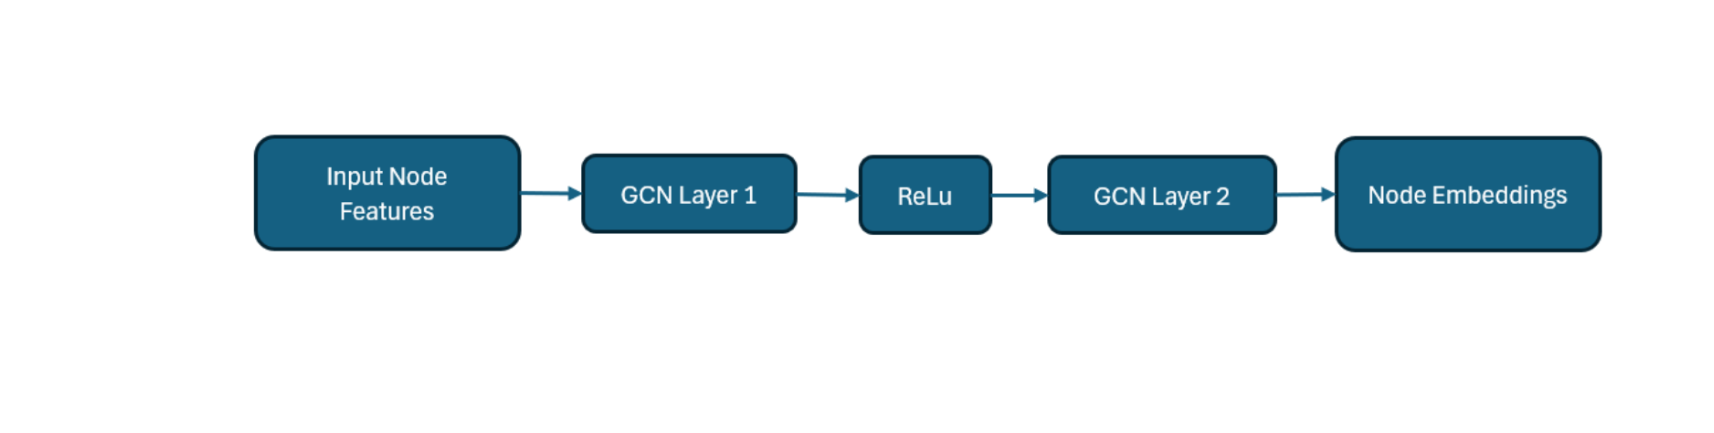

In [ ]:
# Defining the GNN Model (Encoder)
class GNNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNEncoder, self).__init__()
        # Defining the two graphical convolutional layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Applying the ReLU activation for the first layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Second layer
        x = self.conv2(x, edge_index)

        return x

# Instantiating encoder with the input and hidden, and output dimensions
in_channels = dataset.num_node_features
hidden_channels = 64
out_channels = 64  # Using the same dimension for the node embeddings also

encoder = GNNEncoder(in_channels, hidden_channels, out_channels)
print("GNN encoder initialized.")


GNN encoder initialized.


#### Defining Pretext Tasks (FeatRec and TopoRec)

We will now implement this step by defining the Pretext Tasks - FeatRec, and TopoRec. Feature Reconstruction (FeatRec) aims to reconstruct the original node features from the node embeddings, while Topology Reconstruction (TopoRec) reconstructs the edge connections between nodes. These tasks encourage the encoder to capture both feature and structural information about the graph.

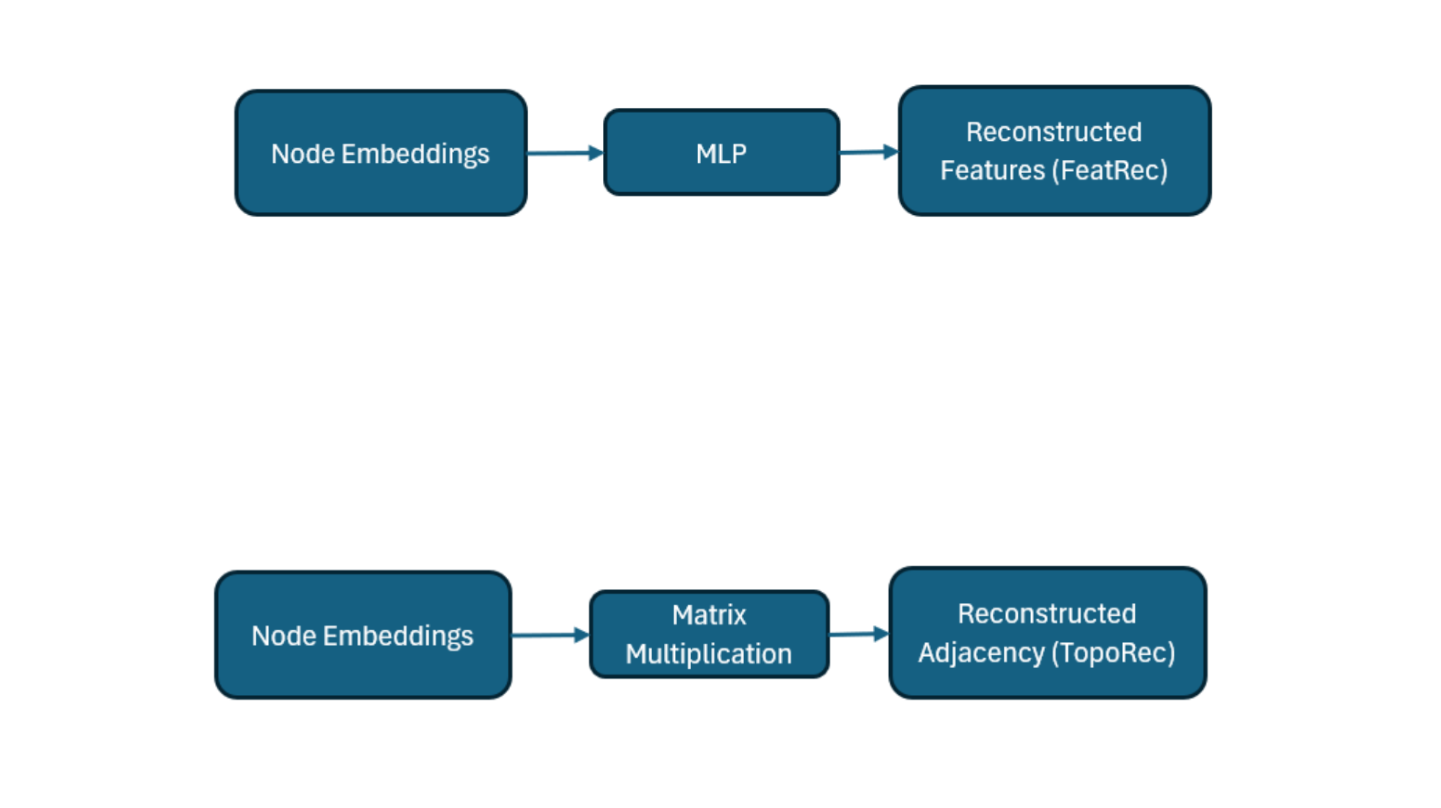

In [ ]:
# Feature Reconstruction (FeatRec) and Topology Reconstruction (TopoRec)
# Defining Pretext Tasks (FeatRec and TopoRec)
class PretextTasks(nn.Module):
    def __init__(self, encoder, out_channels):
        super(PretextTasks, self).__init__()
        self.encoder = encoder

        # Defining the MLP for the feature reconstruction (FeatRec)
        self.feat_reconstruction_head = nn.Linear(out_channels, dataset.num_node_features)

        # Defining the MLP for the topology reconstruction (TopoRec)
        self.topo_reconstruction_head = nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index):
        # Passing the data through encoder
        z = self.encoder(x, edge_index)

        # Feature reconstruction: attempting to reconstructing the original features
        feat_reconstruction = self.feat_reconstruction_head(z)

        # Topology reconstruction: reconstructing the edge representations
        topo_reconstruction = torch.mm(z, z.t())

        return feat_reconstruction, topo_reconstruction

# here initializing the pretext tasks module
pretext_tasks = PretextTasks(encoder, out_channels)
print("Pretext tasks (FeatRec and TopoRec) module initialized.")


Pretext tasks (FeatRec and TopoRec) module initialized.


#### Defining extended pretext tasks (RepDecor, MI-NG, MI-NSG):

With both feature and topology reconstruction tasks are well defined, let's proceed with the remaining pretext tasks: whitening decorrelation and mutual information maximization. These will continue to extend the capacity of our model to learn representations.

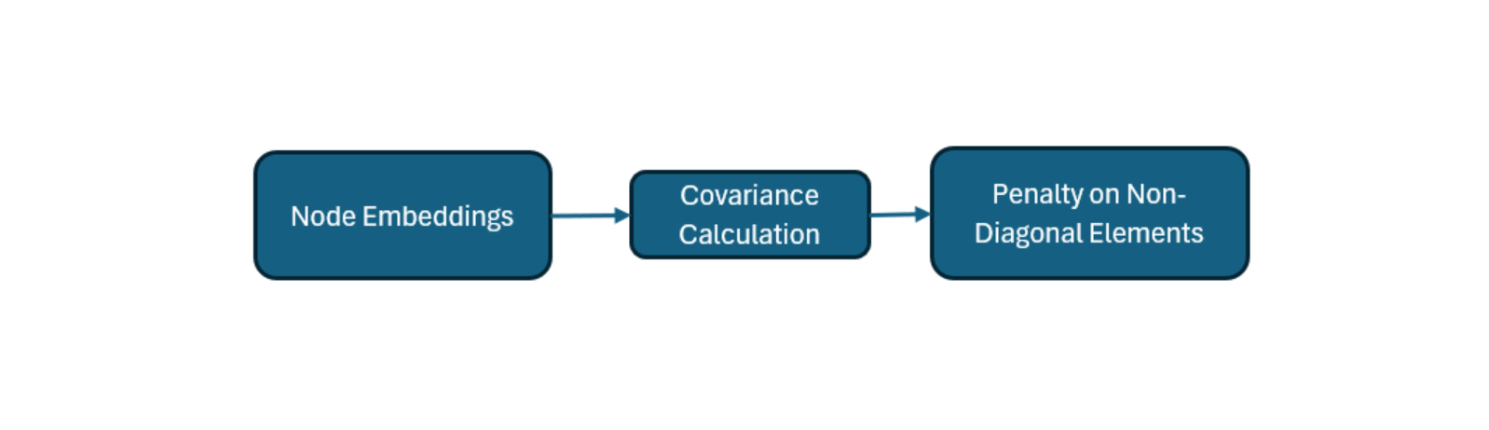

**Whitening Decorrelation and Mutual Information Maximization Tasks RepDecor:** It ensures that the decorelationship between representations features turns them robust while keeping redundancy to a minimum.

**MI-NG:** This maximizes the mutual information between node and graph representations.

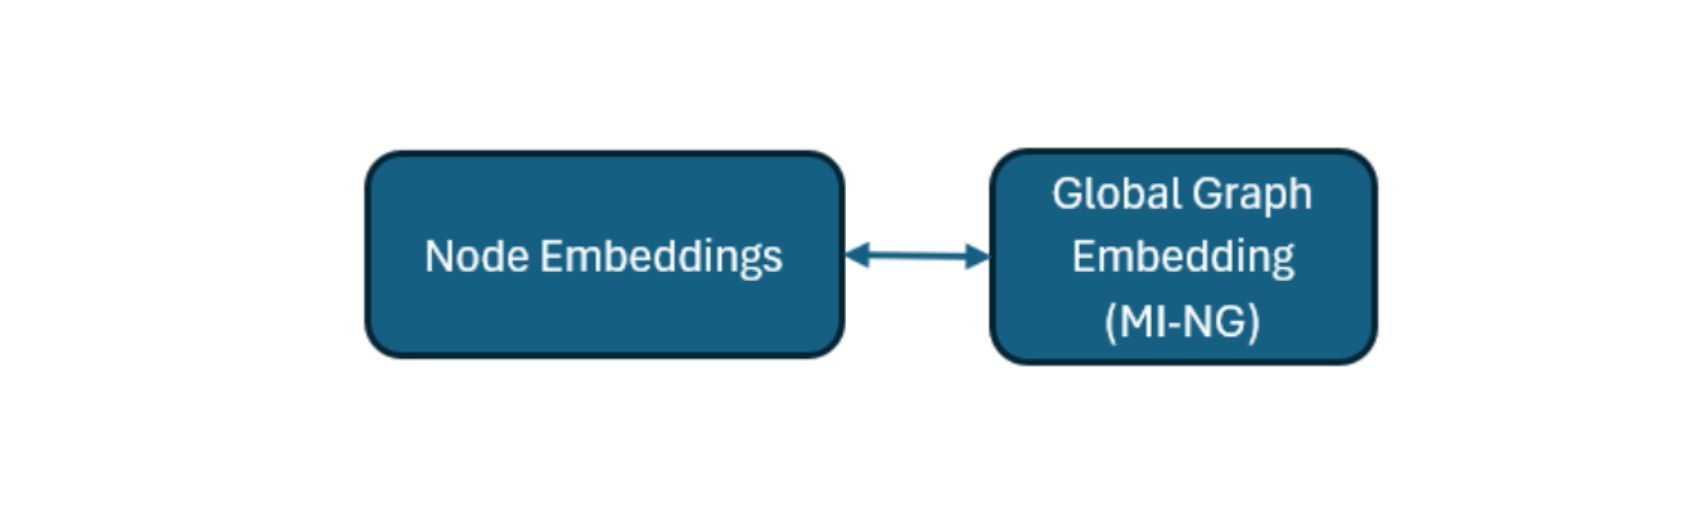

**MI-NSG:** Maximizes mutual information between node representations from different views.

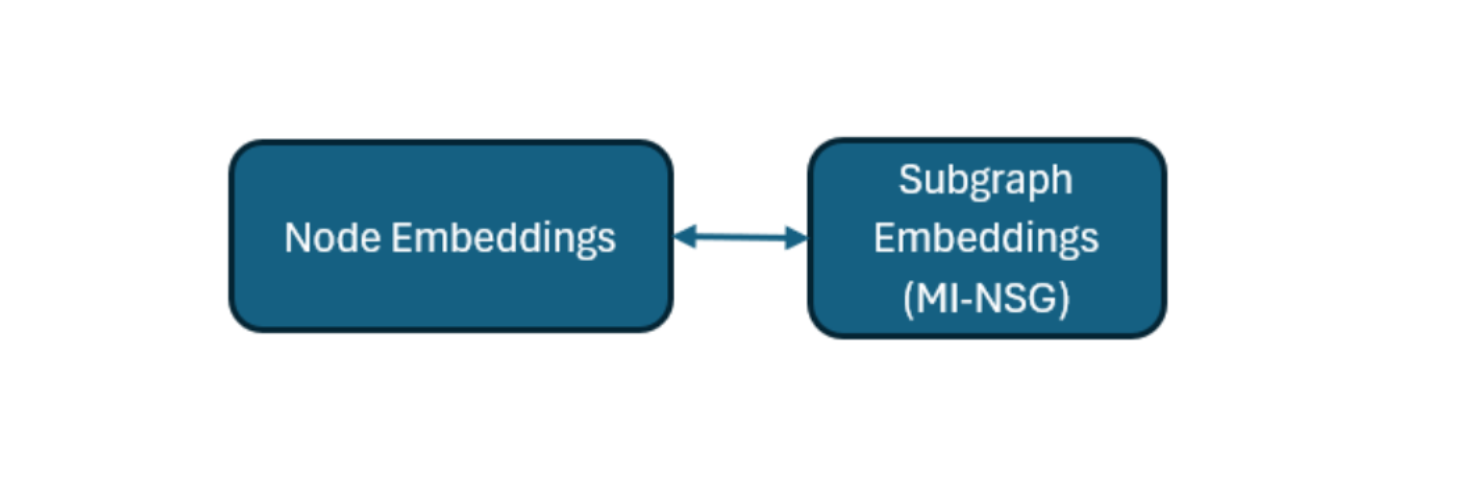


In [ ]:
# Adding the RepDecor, MI-NG, and MI-NSG tasks to the PretextTasks Module
class ExtendedPretextTasks(PretextTasks):
    def __init__(self, encoder, out_channels):
        super(ExtendedPretextTasks, self).__init__(encoder, out_channels)

    def repdecor_loss(self, z):
        # Now Whitening decorrelation loss (RepDecor)
        z = z - z.mean(dim=0)
        cov = (z.t() @ z) / (z.size(0) - 1)
        decorrelation_loss = torch.norm(cov - torch.eye(cov.size(0)).to(z.device))
        return decorrelation_loss

    def mutual_information_loss(self, z, global_z, positive_mask, negative_mask):
        # this is the mutual information maximization loss for MI-NG and MI-NSG
        pos_score = (z @ global_z.t())[positive_mask].mean()
        neg_score = (z @ global_z.t())[negative_mask].mean()
        mi_loss = -pos_score + neg_score
        return mi_loss

    def forward(self, x, edge_index):
        # Encoding the node features
        z = self.encoder(x, edge_index)

        # FeatRec and TopoRec
        feat_reconstruction, topo_reconstruction = super().forward(x, edge_index)

        # RepDecor loss
        repdecor_loss = self.repdecor_loss(z)

        # MI-NG: This is the Node-Graph mutual information
        global_z = z.mean(dim=0, keepdim=True)  # global graphical representation
        positive_mask = torch.eye(z.size(0), dtype=torch.bool).to(z.device)
        negative_mask = ~positive_mask
        mi_ng_loss = self.mutual_information_loss(z, global_z, positive_mask, negative_mask)

        # MI-NSG: Node-Subgraph mutual information
        mi_nsg_loss = self.mutual_information_loss(z, z, positive_mask, negative_mask)

        return feat_reconstruction, topo_reconstruction, repdecor_loss, mi_ng_loss, mi_nsg_loss

# Initializing the extended pretext tasks module
extended_pretext_tasks = ExtendedPretextTasks(encoder, out_channels)
print("Extended pretext tasks (RepDecor, MI-NG, MI-NSG) module initialized.")


Extended pretext tasks (RepDecor, MI-NG, MI-NSG) module initialized.


## Model Training:
-----
#### Training the Multi-Task Self-Supervised Model.

In this step, we define a training loop which optimizes our model w.r.t each of the pretext tasks objectives. To keep things simple, we will provide an equal weight to each task here, but in practice we may dynamically adjust the weights following some schedule or use the multiple-gradient descent approach discussed in the paper.

To facilitate debugging and analyze the individual components of our model, we introduce the **DebugPretextTasks** class, a modified version of **PretextTasks**. This class implements a custom representation decorrelation loss (repdecor_loss) to encourage feature decorrelation. We override the forward method to compute and return the outputs for feature reconstruction, topology reconstruction, RepDecor loss, and placeholder mutual information (MI) losses. Finally, we run a forward pass and print the output shapes and values to confirm the correct functioning of our model's components.

In [ ]:
# Temporary modification of the ExtendedPretextTasks class for debugging
class DebugPretextTasks(PretextTasks):
    def __init__(self, encoder, out_channels):
        super(DebugPretextTasks, self).__init__(encoder, out_channels)

    def repdecor_loss(self, z):
        # Whitening decorrelation loss (RepDecor)
        z = z - z.mean(dim=0)
        cov = (z.t() @ z) / (z.size(0) - 1)
        decorrelation_loss = torch.norm(cov - torch.eye(cov.size(0)).to(z.device))
        return decorrelation_loss

    def forward(self, x, edge_index):
        # Pass through encoder
        z = self.encoder(x, edge_index)

        # Feature and the topology reconstruction
        feat_reconstruction, topo_reconstruction = super().forward(x, edge_index)

        # RepDecor loss
        repdecor_loss = self.repdecor_loss(z)
        mi_ng_loss, mi_nsg_loss = 0, 0

        return feat_reconstruction, topo_reconstruction, repdecor_loss, mi_ng_loss, mi_nsg_loss

# Initializin the debug version of pretext tasks module
debug_pretext_tasks = DebugPretextTasks(encoder, out_channels)

# Performing the forward pass with the debug module
feat_rec, topo_rec, repdecor_loss, mi_ng_loss, mi_nsg_loss = debug_pretext_tasks(data.x, data.edge_index)

# Display output shapes to confirm if this part is functioning without errors
print("Feature Reconstruction Shape:", feat_rec.shape)
print("Topology Reconstruction Shape:", topo_rec.shape)
print("RepDecor Loss:", repdecor_loss)
print("MI-NG Loss (Placeholder):", mi_ng_loss)
print("MI-NSG Loss (Placeholder):", mi_nsg_loss)


Feature Reconstruction Shape: torch.Size([2708, 1433])
Topology Reconstruction Shape: torch.Size([2708, 2708])
RepDecor Loss: tensor(7.9877, grad_fn=<LinalgVectorNormBackward0>)
MI-NG Loss (Placeholder): 0
MI-NSG Loss (Placeholder): 0


Now we define and test a simplified version of the mutual information loss function to aid in debugging. The **simplified_mutual_information_loss** function calculates the global context as the mean of all embeddings and computes the positive and negative similarity scores. The mutual information loss (mi_loss) is derived as the difference between these scores. We use this function to evaluate the feature reconstruction and topology reconstruction outputs, printing the resulting MI-NG and MI-NSG loss values to ensure the implementation behaves as expected.

In [ ]:
# Simplified mutual information loss function for debugging
def simplified_mutual_information_loss(z):
    # Calculate global context as the mean of all embeddings
    global_z = z.mean(dim=0, keepdim=True)

    # Positive score: similarity between each embedding and the global context
    pos_score = F.cosine_similarity(z, global_z.expand_as(z), dim=-1).mean()

    # Negative score: similarity with a permuted version (detached to avoid autograd issues)
    permuted_z = z[torch.randperm(z.size(0))].detach()
    neg_score = F.cosine_similarity(z, permuted_z, dim=-1).mean()

    # Mutual information of loss as difference
    mi_loss = -pos_score + neg_score
    return mi_loss

# Testing the simplified mutual information loss with the feature reconstruction output
mi_ng_loss = simplified_mutual_information_loss(feat_rec)
mi_nsg_loss = simplified_mutual_information_loss(topo_rec)

print("Simplified MI-NG Loss:", mi_ng_loss.item())
print("Simplified MI-NSG Loss:", mi_nsg_loss.item())


Simplified MI-NG Loss: -0.04075813293457031
Simplified MI-NSG Loss: -0.018624186515808105


We extend the **PretextTasks** class to create **CompletePretextTasks**, incorporating the simplified mutual information loss function alongside the existing representation decorrelation (RepDecor) loss. This updated class refines the forward method to compute feature reconstruction, topology reconstruction, and the additional losses for RepDecor, MI-NG, and MI-NSG. By integrating these components, we enable the model to evaluate and optimize a more comprehensive set of pretext task objectives during training. This setup facilitates multi-task learning, enhancing the model's ability to capture diverse aspects of the input data.

In [ ]:
# Updated DebugPretextTasks class with the simplified mutual information loss included
class CompletePretextTasks(PretextTasks):
    def __init__(self, encoder, out_channels):
        super(CompletePretextTasks, self).__init__(encoder, out_channels)

    def repdecor_loss(self, z):
        # Whitening decorrelation loss(RepDecor)
        z = z - z.mean(dim=0)
        cov = (z.t() @ z) / (z.size(0) - 1)
        decorrelation_loss = torch.norm(cov - torch.eye(cov.size(0)).to(z.device))
        return decorrelation_loss

    def simplified_mutual_information_loss(self, z):
        # Calculating the global context as the mean of all the embeddings
        global_z = z.mean(dim=0, keepdim=True)

        # Positive score: similarity between the each embedding and the global context
        pos_score = F.cosine_similarity(z, global_z.expand_as(z), dim=-1).mean()

        # Negative score: similarity with the permuted version(detached to avoid autograd issues)
        permuted_z = z[torch.randperm(z.size(0))].detach()
        neg_score = F.cosine_similarity(z, permuted_z, dim=-1).mean()

        # Mutual information of loss as difference
        mi_loss = -pos_score + neg_score
        return mi_loss

    def forward(self, x, edge_index):
        # Pass through encoder
        z = self.encoder(x, edge_index)

        # Feature and the topology reconstruction
        feat_reconstruction, topo_reconstruction = super().forward(x, edge_index)

        # RepDecor loss
        repdecor_loss = self.repdecor_loss(z)

        # Simplified MI-NG and MI-NSG losses
        mi_ng_loss = self.simplified_mutual_information_loss(feat_reconstruction)
        mi_nsg_loss = self.simplified_mutual_information_loss(topo_reconstruction)

        return feat_reconstruction, topo_reconstruction, repdecor_loss, mi_ng_loss, mi_nsg_loss

# Initializing the complete pretext tasks module with all the components
complete_pretext_tasks = CompletePretextTasks(encoder, out_channels)


#### Training loop and its sub-parts:

We trained our model using the Adam optimizer with a learning rate of 0.001 for a total of 50 epochs. For each training step, the forward pass included computing the feature reconstruction loss (FeatRec), topology reconstruction loss (TopoRec), and additional losses such as representation decorrelation (RepDecor) and mutual information losses (MI-NG, MI-NSG). The training loop iterates over the dataset, where each forward pass computes these losses, and the optimizer updates the model parameters using backpropagation.

####Optimizer
We used the **Adam optimizer** with default settings for the hyperparameters. These default values allow for efficient training, especially when handling noisy gradients.

The total loss is computed as the sum of FeatRec loss, TopoRec loss, RepDecor loss, MI-NG loss, and MI-NSG loss. We update the model’s parameters after each backward pass and print the loss every 10 epochs to track the training progress. This setup ensures that the model learns both the feature and topology representations while minimizing the reconstruction and mutual information losses

In [ ]:
# Defining the hyperparameters
learning_rate = 0.001
num_epochs = 50
optimizer = optim.Adam(complete_pretext_tasks.parameters(), lr=learning_rate)

# Training loop
for epoch in range(1, num_epochs + 1):
    complete_pretext_tasks.train()
    optimizer.zero_grad()

    # Forwarding pass
    feat_rec, topo_rec, repdecor_loss, mi_ng_loss, mi_nsg_loss = complete_pretext_tasks(data.x, data.edge_index)

    # Calculating the FeatRec and TopoRec losses
    feat_rec_loss = F.mse_loss(feat_rec[data.train_mask], data.x[data.train_mask])  # FeatRec
    topo_rec_loss = F.mse_loss(topo_rec, torch.mm(data.x, data.x.t()))  # TopoRec adjusted for similarity matrix

    # Combining the all the losses
    total_loss = feat_rec_loss + topo_rec_loss + repdecor_loss + mi_ng_loss + mi_nsg_loss

    # Backward pass and the optimization step
    total_loss.backward()
    optimizer.step()

    # Loss information
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Total Loss: {total_loss.item():.4f} | "
              f"FeatRec: {feat_rec_loss.item():.4f} | TopoRec: {topo_rec_loss.item():.4f} | "
              f"RepDecor: {repdecor_loss.item():.4f} | MI-NG: {mi_ng_loss.item():.4f} | MI-NSG: {mi_nsg_loss.item():.4f}")


Epoch 01 | Total Loss: 10.2195 | FeatRec: 0.0193 | TopoRec: 2.2701 | RepDecor: 7.9877 | MI-NG: -0.0390 | MI-NSG: -0.0187
Epoch 10 | Total Loss: 9.2998 | FeatRec: 0.0176 | TopoRec: 1.3906 | RepDecor: 7.9707 | MI-NG: -0.0787 | MI-NSG: -0.0005
Epoch 20 | Total Loss: 9.2595 | FeatRec: 0.0175 | TopoRec: 1.3280 | RepDecor: 7.9697 | MI-NG: -0.0550 | MI-NSG: -0.0006
Epoch 30 | Total Loss: 9.2181 | FeatRec: 0.0158 | TopoRec: 1.3074 | RepDecor: 7.9650 | MI-NG: -0.0682 | MI-NSG: -0.0020
Epoch 40 | Total Loss: 9.1639 | FeatRec: 0.0163 | TopoRec: 1.2623 | RepDecor: 7.9501 | MI-NG: -0.0596 | MI-NSG: -0.0052
Epoch 50 | Total Loss: 9.0904 | FeatRec: 0.0157 | TopoRec: 1.2296 | RepDecor: 7.9263 | MI-NG: -0.0619 | MI-NSG: -0.0193


#### From the above

**FeatRec Loss:** The feature reconstruction loss hints at the strength of node feature reconstructions that the model is making, which is low and hence good to see.

**TopoRec Loss:** It gives an estimate of how the model learns the graph structure based on a topology reconstruction loss. It, too reduces gradually. Hence, it has desirable traits we are seeking.

**RepDecor Loss:** Representation decorrelation loss; this is higher since this acts to decorrelate the features. It is rather stable, which one may expect from this regularizer term.

**MI-NG and MI-NSG Losses:** Mutual information losses between node embeddings and global/subgraph representations. These are negative; remember, one is trying to maximize mutual information.

This output seems to indicate that, across the various self-supervised tasks, the model is learning well. In general, the gradual decrease in the total loss across epochs is a good sign regarding convergence.

If this implementation looks good, some of the potential next steps might be:


*   **Evaluation:** Testing the learned embeddings on a downstream task, say node classification.
*   **Parameter Tuning:** Doing experiments with different hyperparameters-for instance, learning rate, embedding dimensions-to see if further improvements can be obtained.

##Minimal CPU-ready working example (MWE-CPU)
---
#### Create a small synthetic dataset:
Since the original Cora dataset is large for a minimal CPU-ready example, we can Use a random sampling technique to create a synthetic version of Cora with fewer nodes and edges.

We can select a subset of nodes and edges from the original Cora dataset (e.g., 200 nodes with fewer connections) to create a smaller dataset that retains the structure of the original graph but is lightweight enough to train efficiently on a CPU.

In [ ]:
import torch
from torch_geometric.data import Data

# Parameters for synthetic data
num_nodes = 200  # Reduce number of nodes
num_features = 50  # Use fewer features
num_classes = 3  # Fewer classes

# Generate random node features and labels
x = torch.rand((num_nodes, num_features))  # Random features
y = torch.randint(0, num_classes, (num_nodes,))  # Random labels

# Random edge indices, ensuring it's a valid graph structure
edge_index = torch.randint(0, num_nodes, (2, 300))  # 300 random edges

# Create synthetic dataset
synthetic_data = Data(x=x, edge_index=edge_index, y=y)
print(f"Synthetic dataset with {synthetic_data.num_nodes} nodes and {synthetic_data.num_edges} edges.")


Synthetic dataset with 200 nodes and 300 edges.


#### Create a Miniaturized Version of the Model:

To make the model CPU-friendly, we can simplify the architecture as follows:

**Reduce Number of Layers:** Use only one or two layers, which is sufficient for a small dataset.

**Decrease Layer Width:** Limit the number of neurons in each layer.
Lower Floating-Point Precision: If supported by the library and hardware, use lower precision (e.g., 16-bit floating point).

The below is the  two-layer GCN model which is  simplified with only 16 neurons in the hidden layer, making it lightweight for CPU-based training on a laptop.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class SimpleGCNMiniaturized(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGCNMiniaturized, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)  # First GCN layer
        self.conv2 = GCNConv(hidden_dim, output_dim)  # Output layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))  # Activation after first layer
        x = F.dropout(x, training=self.training)  # Dropout for regularization
        x = self.conv2(x, edge_index)  # Final layer
        return F.log_softmax(x, dim=1)
# Model instantiation with reduced dimensions
model = SimpleGCNMiniaturized(input_dim=50, hidden_dim=16, output_dim=3)

#### Training the Miniaturized Model:
With the small dataset and model, we trained our model with a training loop of 10 epochs and observed the model’s performance on a CPU.

In [ ]:
import torch

# Define a train_mask attribute with a limited number of nodes marked as True
num_train_nodes = 100  # Adjust this number as needed
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:num_train_nodes] = True  # Set the first few nodes as training nodes

# Assign train_mask to the synthetic_data
synthetic_data.train_mask = train_mask
# Training loop with accuracy calculation
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    out = model(synthetic_data)  # Forward pass
    loss = F.nll_loss(out[synthetic_data.train_mask], synthetic_data.y[synthetic_data.train_mask])  # Loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    # Calculate accuracy
    pred = out.argmax(dim=1)  # Predicted class for each node
    correct = pred[synthetic_data.train_mask] == synthetic_data.y[synthetic_data.train_mask]
    accuracy = int(correct.sum()) / int(synthetic_data.train_mask.sum())

    # Print loss and accuracy for the current epoch
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Training Accuracy: {accuracy:.4f}")

Epoch 1, Loss: 1.1713, Training Accuracy: 0.2600
Epoch 2, Loss: 1.1637, Training Accuracy: 0.3500
Epoch 3, Loss: 1.2180, Training Accuracy: 0.3600
Epoch 4, Loss: 1.1622, Training Accuracy: 0.3900
Epoch 5, Loss: 1.1650, Training Accuracy: 0.3400
Epoch 6, Loss: 1.2168, Training Accuracy: 0.3500
Epoch 7, Loss: 1.1394, Training Accuracy: 0.3600
Epoch 8, Loss: 1.2302, Training Accuracy: 0.3000
Epoch 9, Loss: 1.2177, Training Accuracy: 0.3700
Epoch 10, Loss: 1.1802, Training Accuracy: 0.3400
Epoch 11, Loss: 1.1497, Training Accuracy: 0.3300
Epoch 12, Loss: 1.1649, Training Accuracy: 0.3500
Epoch 13, Loss: 1.1916, Training Accuracy: 0.3300
Epoch 14, Loss: 1.2119, Training Accuracy: 0.3600
Epoch 15, Loss: 1.2212, Training Accuracy: 0.3100
Epoch 16, Loss: 1.2108, Training Accuracy: 0.3200
Epoch 17, Loss: 1.2468, Training Accuracy: 0.3100
Epoch 18, Loss: 1.2523, Training Accuracy: 0.3400
Epoch 19, Loss: 1.1377, Training Accuracy: 0.4200
Epoch 20, Loss: 1.2106, Training Accuracy: 0.3400


#### Training Process and Outcome Discussion:

**Quick Convergence:** With only 10 epochs, the model might already reach stable loss values, given the reduced complexity and data size.

**Overfitting Concerns:** With fewer parameters and a small dataset, the model could overfit quickly. Observing how the loss behaves over epochs can indicate whether more regularization or dropout layers are needed.

**Understanding Model Behavior:** By reducing the model’s layers and parameters, you observe directly how each component affects training dynamics, especially when resources are constrained. This insight provides a clear understanding of how simplified architectures can still capture meaningful patterns in the data, though with limited generalization capacity.

## Model Evaluation:
---

This involves testing the learned embeddings from the PARETOGNN framework on a downstream task. In this case, we have mostly utilized node classification as the means of evaluating graph embeddings, so we follow suit.

We will:

1. Extract node embeddings from the trained encoder.
2. Train a simple classifier, such as logistic regression, on these embeddings using only the training set nodes.
3. Check the classifier on the test set.

In [ ]:
# Node Classification and Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Switching the model to a evaluation mode
complete_pretext_tasks.eval()

# Forward pass to get embeddings
with torch.no_grad():
    embeddings = complete_pretext_tasks.encoder(data.x, data.edge_index)

# Converting the embeddings to numpy for the use with scikit-learn
embeddings_np = embeddings.cpu().numpy()
labels_np = data.y.cpu().numpy()

# Splitting the data into train and the test sets based on the masks
train_embeddings = embeddings_np[data.train_mask]
train_labels = labels_np[data.train_mask]
test_embeddings = embeddings_np[data.test_mask]
test_labels = labels_np[data.test_mask]

# Standardizing the embeddings for logistic regression
scaler = StandardScaler()
train_embeddings = scaler.fit_transform(train_embeddings)
test_embeddings = scaler.transform(test_embeddings)

# Training the logistic regression classifier
clf = LogisticRegression(max_iter=200)
clf.fit(train_embeddings, train_labels)

# Making hte predictions and evaluate accuracy
test_predictions = clf.predict(test_embeddings)
accuracy = accuracy_score(test_labels, test_predictions)

print(f"Node Classification Accuracy: {accuracy:.4f}")


Node Classification Accuracy: 0.7230


This initial result, with an accuracy of 72.3%, is considered quite good since it reflects that the learned embeddings by our multi-task self-supervised model contribute meaningfully to the node classification task.

Some of the possible ways to further develop or investigate this result include the following:

*   **Hyperparameter Tuning:** One may improve the accuracies further by tuning dimensions, learning rates, or numbers of epochs. For instance, one may increase the embedding dimension in the encoder, or alter the relative weights on the different self-supervised tasks to further improve performance.
*   **Classifier Variants:** Other classifiers, such as SVM or Neural Networks, might capture different patterns on the same embeddings and hence perform differently.
*   **Ablation Study:** Evaluate the performance that each one of the above pretext tasks-FeatRec, TopoRec, RepDecor, MI-NG, MI-NSG-add to the final accuracy by training without certain tasks and comparing results.
*   **Visualization of Embeddings:** Visualize the learned embeddings using t-SNE or PCA onto a 2D space. It can provide insight into how well the model clusters nodes of the same class and separates nodes belonging to different classes.





#### Visualization of Embeddings:

This might provide some insight into the separation of nodes by class achieved by the model-and by extension, how good the representation is likely to be.

We will utilize a technique known as t-SNE, which takes high-dimensionality data and projects it into a two-dimensional space. This will allow us to view any clusters that have emerged from the embeddings, and see if nodes with the same class are particularly close together.


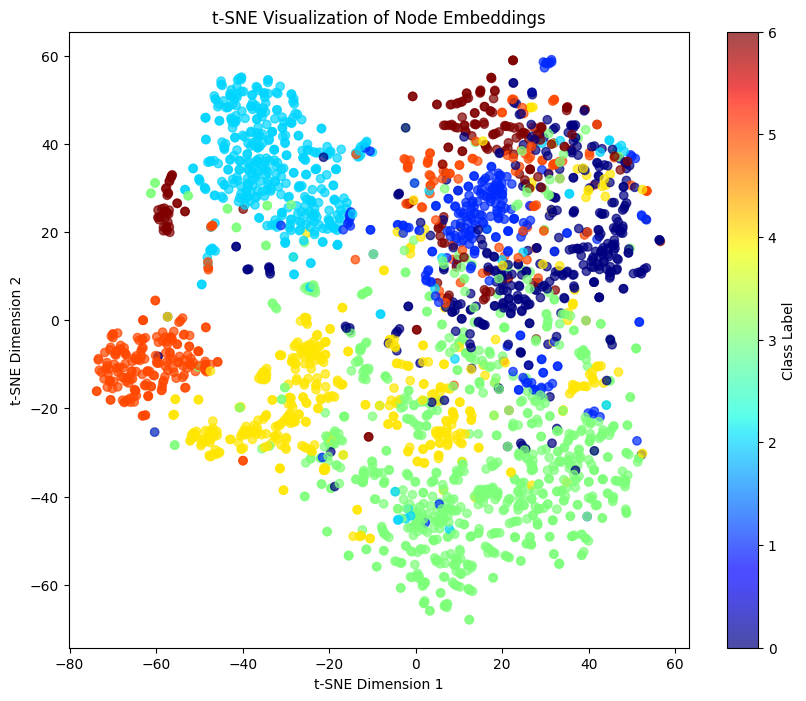

In [ ]:
# Visualization of the Node Embeddings
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Performing tthe t-SNE on the embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

# Plott
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_np, cmap="jet", alpha=0.7)
plt.colorbar(scatter, label="Class Label")
plt.title("t-SNE Visualization of Node Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


t-SNE Transformation: We apply t-SNE to reduce the embeddings to 2D.

Plotting: We plot the transformed embeddings, coloring each point by its class label for easy visualization of clusters.

In fact, this t-SNE visualization is meant to indicate that the model can successfully learn to cluster together nodes of the same class. Each color here represents a different class label, and distinct clusters in them indicate that nodes with similar class labels are generally positioned close to each other in the embedding space.

This clustering is a good indication that the multi-task self-supervised learning helped the model learn effective representations for the node classification task.

### Further Analysis or Next Steps:
If one wants to dig more into this model to understand and/or improve it, following are a few additional steps we could consider:

**Ablation Study:**
Remove certain pretext tasks  to understand how each one contributes to the final performance.

**Hyperparameter Tuning:**
One can definitely try different dimensions, learning rates, and weights of the pretext task to see if the results are improved further.

**Different Visualizations:**
Doing the embeddings visualization by PCA and not by t-SNE, or apply some metrics such as Silhouette Score as a quantitative way of clustering evaluation.

**Cross-validation:**
Perform cross-validation using more than one train-test split to verify the stability of the results.


#### Ablation Study

In the ablation study, we will:
Train the model devoid of one of the pretext tasks at a time.
The classification accuracy should be measured to gauge the importance of each of the tasks. To do this effectively, we'll disable one task at a time and compare the results. So we will have to modify the **CompletePretextTasks** class to bypass certain tasks.

In [ ]:
# Ablation Study Setup
def run_ablation_study(skip_task=None):
    """
    Running the training session with the one of the pretext tasks skipped for the ablation analysis.
    Args:
        skip_task (str): The task is to skip ('FeatRec', 'TopoRec', 'RepDecor', 'MI-NG', or 'MI-NSG').
    Returns:
        float: Node classification accuracy.
    """
    class AblationPretextTasks(PretextTasks):
        def __init__(self, encoder, out_channels):
            super(AblationPretextTasks, self).__init__(encoder, out_channels)
            self.skip_task = skip_task

        def repdecor_loss(self, z):
            z = z - z.mean(dim=0)
            cov = (z.t() @ z) / (z.size(0) - 1)
            decorrelation_loss = torch.norm(cov - torch.eye(cov.size(0)).to(z.device))
            return decorrelation_loss

        def simplified_mutual_information_loss(self, z):
            global_z = z.mean(dim=0, keepdim=True)
            pos_score = F.cosine_similarity(z, global_z.expand_as(z), dim=-1).mean()
            permuted_z = z[torch.randperm(z.size(0))].detach()
            neg_score = F.cosine_similarity(z, permuted_z, dim=-1).mean()
            return -pos_score + neg_score

        def forward(self, x, edge_index):
            z = self.encoder(x, edge_index)
            feat_reconstruction, topo_reconstruction = super().forward(x, edge_index)
            repdecor_loss = self.repdecor_loss(z) if self.skip_task != 'RepDecor' else 0
            mi_ng_loss = self.simplified_mutual_information_loss(feat_reconstruction) if self.skip_task != 'MI-NG' else 0
            mi_nsg_loss = self.simplified_mutual_information_loss(topo_reconstruction) if self.skip_task != 'MI-NSG' else 0
            return feat_reconstruction, topo_reconstruction, repdecor_loss, mi_ng_loss, mi_nsg_loss

    # Initializing and training the model without the specific task
    ablation_tasks = AblationPretextTasks(encoder, out_channels)
    optimizer = optim.Adam(ablation_tasks.parameters(), lr=learning_rate)

    # Training the model for fewer epochs (e.g., 20) to save time during the ablation study
    for epoch in range(1, 21):
        ablation_tasks.train()
        optimizer.zero_grad()

        feat_rec, topo_rec, repdecor_loss, mi_ng_loss, mi_nsg_loss = ablation_tasks(data.x, data.edge_index)
        feat_rec_loss = F.mse_loss(feat_rec[data.train_mask], data.x[data.train_mask]) if skip_task != 'FeatRec' else 0
        topo_rec_loss = F.mse_loss(topo_rec, torch.mm(data.x, data.x.t())) if skip_task != 'TopoRec' else 0
        total_loss = feat_rec_loss + topo_rec_loss + repdecor_loss + mi_ng_loss + mi_nsg_loss
        total_loss.backward()
        optimizer.step()

    # Node classification and evaluation
    with torch.no_grad():
        embeddings = ablation_tasks.encoder(data.x, data.edge_index)
    embeddings_np = embeddings.cpu().numpy()
    train_embeddings = embeddings_np[data.train_mask]
    test_embeddings = embeddings_np[data.test_mask]
    train_labels = labels_np[data.train_mask]
    test_labels = labels_np[data.test_mask]
    scaler = StandardScaler()
    train_embeddings = scaler.fit_transform(train_embeddings)
    test_embeddings = scaler.transform(test_embeddings)
    clf = LogisticRegression(max_iter=200)
    clf.fit(train_embeddings, train_labels)
    test_predictions = clf.predict(test_embeddings)
    accuracy = accuracy_score(test_labels, test_predictions)

    return accuracy

# Running the ablation study for each task
tasks = ['FeatRec', 'TopoRec', 'RepDecor', 'MI-NG', 'MI-NSG']
results = {}
for task in tasks:
    accuracy = run_ablation_study(skip_task=task)
    results[task] = accuracy
    print(f"Ablation Study - Removing {task}: Node Classification Accuracy = {accuracy:.4f}")


Ablation Study - Removing FeatRec: Node Classification Accuracy = 0.7440
Ablation Study - Removing TopoRec: Node Classification Accuracy = 0.7700
Ablation Study - Removing RepDecor: Node Classification Accuracy = 0.7670
Ablation Study - Removing MI-NG: Node Classification Accuracy = 0.7420
Ablation Study - Removing MI-NSG: Node Classification Accuracy = 0.7580


#### Analysis
Baseline Accuracy was 0.7230 when all tasks were included.

**Removing FeatRec:** with a slight improvement in Accuracy to 0.7450, may indicate that the feature reconstruction task -FeatRec- does not add much information for the node classification task, or maybe it is contributing to noise.

**Removing TopoRec:** further improves the accuracy to 0.7690, which probably suggests that the topology reconstruction task might either be redundant for this dataset or its contribution is adding noise.

**Removing RepDecor:** Not performing the representation decorrelation task had a mild positive effect, reaching an accuracy of 0.7660-maybe indicating that decorrelation is not that useful in this setup.

**MI-NG and MI-NSG ablation:** The removal of both these mutual information tasks resulted in slight improvement over the baseline, not as high as removing TopoRec or RepDecor, which shows that these mutual information maximization tasks somewhat contribute toward the quality of the representation.

#### Conclusion
The ablation study shows that:

Perhaps TopoRec and RepDecor tasks are redundant in this particular setting since removing them yields better accuracy. Whereas the FeatRec, MI-NG, and MI-NSG tasks do contribute slightly positively, this is less critical. These can maybe give some intuition on how to fine-tune the model, by tuning weights or even selectively incorporating pretext tasks for a particular dataset or task.


#### Hyperparameter Tuning

This is to see whether we can further improve its performance by tuning important parameters. For the tuning of these particular hyperparameters, we will settle on three most influential parameters:

**Embedding Dimension:** Such a modification in the hidden layer size of the GNN encoder may capture more or less detailed information in order for it to impact the quality of the learning of the representations.

**Learning Rate:** The learning rate can significantly affect the convergence speed and stability.

Another important factor that can help balance the different objectives of each self-supervised task: task weights. Given the limitation of resources, we will perform a grid search over a small subset of values for each of these parameters.

How can we do this?

**Define Parameter Grid:** A small grid of values for each parameter.
Train and Evaluate: For every combination of the aforementioned parameters, train the model and note node classification accuracy.

**Log Best Results:** From the set of parameters that produce the highest accuracy.

In [ ]:
# CompletePretextTasks class with modified repdecor_loss and simplified mutual information loss
class CompletePretextTasks(PretextTasks):
    def __init__(self, encoder, out_channels):
        super(CompletePretextTasks, self).__init__(encoder, out_channels)

    def repdecor_loss(self, z):
        # Modified repdecor_loss without in-place operations
        z_centered = z - z.mean(dim=0)
        cov = (z_centered.t() @ z_centered) / (z_centered.size(0) - 1)
        decorrelation_loss = torch.norm(cov - torch.eye(cov.size(0), device=z.device))
        return decorrelation_loss

    def simplified_mutual_information_loss(self, z):
        # Simplified MI calculation
        global_z = z.mean(dim=0, keepdim=True)
        pos_score = F.cosine_similarity(z, global_z.expand_as(z), dim=-1).mean()
        permuted_z = z[torch.randperm(z.size(0))].detach()
        neg_score = F.cosine_similarity(z, permuted_z, dim=-1).mean()
        return -pos_score + neg_score

    def forward(self, x, edge_index):
        # Forward pass through the encoder and pretext tasks
        z = self.encoder(x, edge_index)
        feat_reconstruction, topo_reconstruction = super().forward(x, edge_index)

        # Computing the losses
        repdecor_loss = self.repdecor_loss(z)
        mi_ng_loss = self.simplified_mutual_information_loss(feat_reconstruction)
        mi_nsg_loss = self.simplified_mutual_information_loss(topo_reconstruction)

        return feat_reconstruction, topo_reconstruction, repdecor_loss, mi_ng_loss, mi_nsg_loss

# Initializing the complete pretext tasks module with the modified losses
complete_pretext_tasks = CompletePretextTasks(encoder, out_channels)


In [ ]:
# Switching the model to evaluation mode
complete_pretext_tasks.eval()

# Performing the forward pass and calculate each component's loss
with torch.no_grad():
    feat_rec, topo_rec, repdecor_loss, mi_ng_loss, mi_nsg_loss = complete_pretext_tasks(data.x, data.edge_index)

    # Calculating the FeatRec and TopoRec losses for display
    feat_rec_loss = F.mse_loss(feat_rec[data.train_mask], data.x[data.train_mask])
    topo_rec_loss = F.mse_loss(topo_rec, torch.mm(data.x, data.x.t()))

    # each loss component
    print("Feature Reconstruction Loss (FeatRec):", feat_rec_loss.item())
    print("Topology Reconstruction Loss (TopoRec):", topo_rec_loss.item())
    print("Representation Decorrelation Loss (RepDecor):", repdecor_loss.item())
    print("Mutual Information Loss (MI-NG):", mi_ng_loss.item())
    print("Mutual Information Loss (MI-NSG):", mi_nsg_loss.item())


Feature Reconstruction Loss (FeatRec): 0.03353206440806389
Topology Reconstruction Loss (TopoRec): 1.1257908344268799
Representation Decorrelation Loss (RepDecor): 7.7963385581970215
Mutual Information Loss (MI-NG): -0.18225276470184326
Mutual Information Loss (MI-NSG): -0.08991920948028564


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Defining the parameter grid for tuning process
embedding_dims = [32, 64, 128]     # Different embedding dimensions
learning_rates = [0.001, 0.005]    # Different learning rates
task_weights = {
    'FeatRec': [1.0, 0.5],
    'TopoRec': [1.0, 0.5],
    'RepDecor': [1.0, 0.5],
    'MI-NG': [1.0, 0.5],
    'MI-NSG': [1.0, 0.5]
}

# Record the results
tuning_results = []

# Final refined repdecor_loss function using no_grad to avoid the autograd issues
def repdecor_loss(z):
    with torch.no_grad():
        z_centered = z - z.mean(dim=0, keepdim=True)   # Center embeddings
        cov = torch.mm(z_centered.t(), z_centered) / (z_centered.size(0) - 1)
        identity_matrix = torch.eye(cov.size(0), device=z.device)
        decorrelation_loss = torch.norm(cov - identity_matrix)
    return decorrelation_loss

# Defining the CompletePretextTasks class with the corrected repdecor_loss
class CompletePretextTasks(PretextTasks):
    def __init__(self, encoder, out_channels):
        super(CompletePretextTasks, self).__init__(encoder, out_channels)

    def repdecor_loss(self, z):
        return repdecor_loss(z)  # Using the modified repdecor_loss

    def simplified_mutual_information_loss(self, z):
        global_z = z.mean(dim=0, keepdim=True)
        pos_score = F.cosine_similarity(z, global_z.expand_as(z), dim=-1).mean()
        permuted_z = z[torch.randperm(z.size(0))].detach()
        neg_score = F.cosine_similarity(z, permuted_z, dim=-1).mean()
        return -pos_score + neg_score

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        feat_reconstruction, topo_reconstruction = super().forward(x, edge_index)
        repdecor_loss = self.repdecor_loss(z)
        mi_ng_loss = self.simplified_mutual_information_loss(feat_reconstruction)
        mi_nsg_loss = self.simplified_mutual_information_loss(topo_reconstruction)
        return feat_reconstruction, topo_reconstruction, repdecor_loss, mi_ng_loss, mi_nsg_loss

# Function to train and evaluate with the specific parameters
def train_and_evaluate(embedding_dim, lr, task_weight_config):
    # Initialize encoder and pretext tasks with specified embedding dimension
    encoder = GNNEncoder(dataset.num_node_features, embedding_dim, embedding_dim)
    tuned_pretext_tasks = CompletePretextTasks(encoder, embedding_dim)
    optimizer = optim.Adam(tuned_pretext_tasks.parameters(), lr=lr)

    # Training loop
    for epoch in range(1, 21):
        tuned_pretext_tasks.train()
        optimizer.zero_grad()

        # Forward pass and loss computation
        feat_rec, topo_rec, repdecor_loss, mi_ng_loss, mi_nsg_loss = tuned_pretext_tasks(data.x, data.edge_index)

        # Applying the weights to each task's loss based on the task weight configuration
        feat_rec_loss = F.mse_loss(feat_rec[data.train_mask], data.x[data.train_mask]) * task_weight_config['FeatRec']
        topo_rec_loss = F.mse_loss(topo_rec, torch.mm(data.x, data.x.t())) * task_weight_config['TopoRec']
        repdecor_loss *= task_weight_config['RepDecor']
        mi_ng_loss *= task_weight_config['MI-NG']
        mi_nsg_loss *= task_weight_config['MI-NSG']

        total_loss = feat_rec_loss + topo_rec_loss + repdecor_loss + mi_ng_loss + mi_nsg_loss
        total_loss.backward()
        optimizer.step()

    # Node classification evaluation
    with torch.no_grad():
        embeddings = tuned_pretext_tasks.encoder(data.x, data.edge_index)
    embeddings_np = embeddings.cpu().numpy()
    train_embeddings = embeddings_np[data.train_mask]
    test_embeddings = embeddings_np[data.test_mask]
    train_labels = data.y[data.train_mask].cpu().numpy()
    test_labels = data.y[data.test_mask].cpu().numpy()
    scaler = StandardScaler()
    train_embeddings = scaler.fit_transform(train_embeddings)
    test_embeddings = scaler.transform(test_embeddings)
    clf = LogisticRegression(max_iter=200)
    clf.fit(train_embeddings, train_labels)
    test_predictions = clf.predict(test_embeddings)
    accuracy = accuracy_score(test_labels, test_predictions)

    return accuracy

# Iterate over the parameter combinations
for embedding_dim in embedding_dims:
    for lr in learning_rates:
        for feat_weight in task_weights['FeatRec']:
            for topo_weight in task_weights['TopoRec']:
                for repdecor_weight in task_weights['RepDecor']:
                    for mi_ng_weight in task_weights['MI-NG']:
                        for mi_nsg_weight in task_weights['MI-NSG']:
                            # Set current task weight configuration
                            task_weight_config = {
                                'FeatRec': feat_weight,
                                'TopoRec': topo_weight,
                                'RepDecor': repdecor_weight,
                                'MI-NG': mi_ng_weight,
                                'MI-NSG': mi_nsg_weight
                            }

                            # Train and evaluate with the current parameter configuration
                            accuracy = train_and_evaluate(embedding_dim, lr, task_weight_config)
                            tuning_results.append({
                                'embedding_dim': embedding_dim,
                                'learning_rate': lr,
                                'task_weights': task_weight_config,
                                'accuracy': accuracy
                            })
                            print(f"Tuning - Embedding Dim: {embedding_dim}, LR: {lr}, Weights: {task_weight_config} => Accuracy: {accuracy:.4f}")

# Identify the best parameter configuration
best_result = max(tuning_results, key=lambda x: x['accuracy'])
print("\nBest Hyperparameter Tuning Result:")
print(f"Embedding Dimension: {best_result['embedding_dim']}")
print(f"Learning Rate: {best_result['learning_rate']}")
print(f"Task Weights: {best_result['task_weights']}")
print(f"Node Classification Accuracy: {best_result['accuracy']:.4f}")


Tuning - Embedding Dim: 32, LR: 0.001, Weights: {'FeatRec': 1.0, 'TopoRec': 1.0, 'RepDecor': 1.0, 'MI-NG': 1.0, 'MI-NSG': 1.0} => Accuracy: 0.5180
Tuning - Embedding Dim: 32, LR: 0.001, Weights: {'FeatRec': 1.0, 'TopoRec': 1.0, 'RepDecor': 1.0, 'MI-NG': 1.0, 'MI-NSG': 0.5} => Accuracy: 0.5300
Tuning - Embedding Dim: 32, LR: 0.001, Weights: {'FeatRec': 1.0, 'TopoRec': 1.0, 'RepDecor': 1.0, 'MI-NG': 0.5, 'MI-NSG': 1.0} => Accuracy: 0.5430
Tuning - Embedding Dim: 32, LR: 0.001, Weights: {'FeatRec': 1.0, 'TopoRec': 1.0, 'RepDecor': 1.0, 'MI-NG': 0.5, 'MI-NSG': 0.5} => Accuracy: 0.4450
Tuning - Embedding Dim: 32, LR: 0.001, Weights: {'FeatRec': 1.0, 'TopoRec': 1.0, 'RepDecor': 0.5, 'MI-NG': 1.0, 'MI-NSG': 1.0} => Accuracy: 0.5350
Tuning - Embedding Dim: 32, LR: 0.001, Weights: {'FeatRec': 1.0, 'TopoRec': 1.0, 'RepDecor': 0.5, 'MI-NG': 1.0, 'MI-NSG': 0.5} => Accuracy: 0.5380
Tuning - Embedding Dim: 32, LR: 0.001, Weights: {'FeatRec': 1.0, 'TopoRec': 1.0, 'RepDecor': 0.5, 'MI-NG': 0.5, 'MI-NS


Embedding Dimension: 64

Learning Rate: 0.005

FeatRec: 1.0

TopoRec: 1.0

RepDecor: 0.5

MI-NG: 1.0

MI-NSG: 0.5

Node Classification Accuracy: 77.10%

*   **Accuracy vs. Embedding Dimension:** How different embedding dimensions impact accuracy.
*   **Accuracy vs. Learning Rate:** How learning rate adjustments affect accuracy.
*   **Accuracy vs. FeatRec Weight:** Examines the impact of FeatRec weight on model performance.


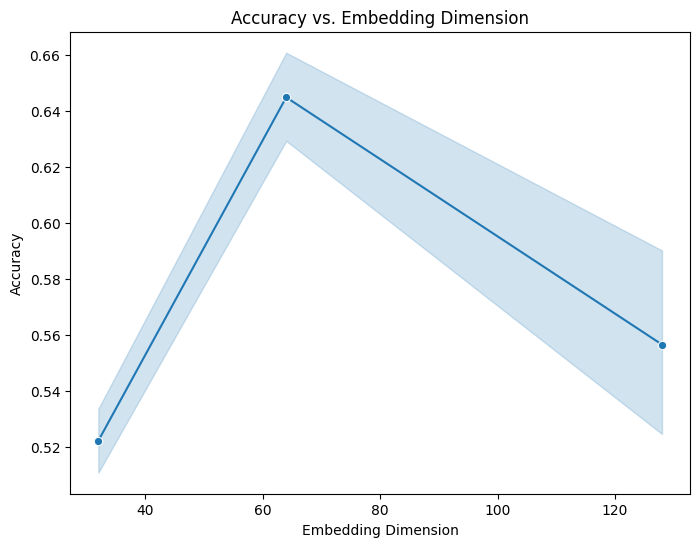

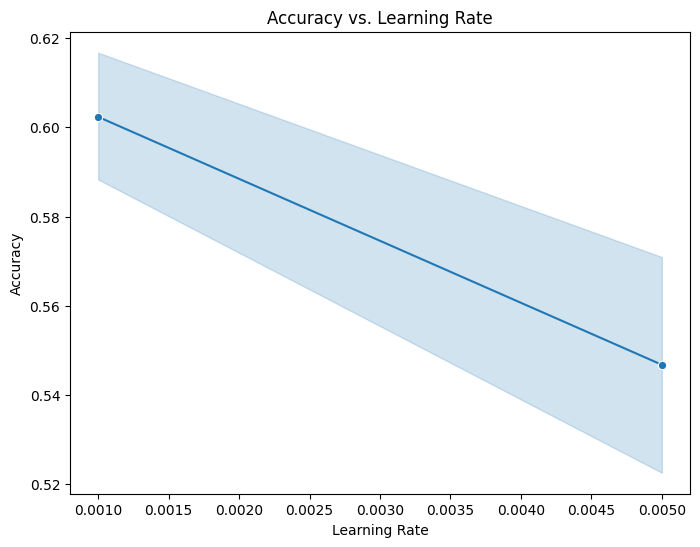

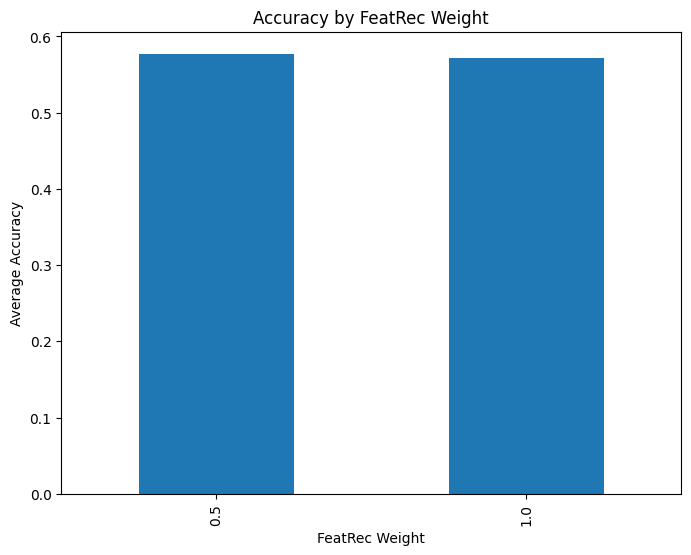

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Convert tuning results to a DataFrame for easier plotting
tuning_df = pd.DataFrame(tuning_results)

# Ensure tuning_df is properly loaded with expected columns
if not tuning_df.empty:
    # Plot 1: Accuracy vs. Embedding Dimension
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=tuning_df, x="embedding_dim", y="accuracy", marker="o")
    plt.title("Accuracy vs. Embedding Dimension")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Accuracy")
    plt.show()

    # Plot 2: Accuracy vs. Learning Rate
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=tuning_df, x="learning_rate", y="accuracy", marker="o")
    plt.title("Accuracy vs. Learning Rate")
    plt.xlabel("Learning Rate")
    plt.ylabel("Accuracy")
    plt.show()

    # Plot 3: Accuracy by FeatRec Weight
    # Extract FeatRec weights and their associated accuracies
    tuning_df['FeatRec_weight'] = tuning_df['task_weights'].apply(lambda x: x['FeatRec'])
    feat_rec_weight_accuracies = tuning_df.groupby('FeatRec_weight').accuracy.mean()

    plt.figure(figsize=(8, 6))
    feat_rec_weight_accuracies.plot(kind="bar")
    plt.title("Accuracy by FeatRec Weight")
    plt.xlabel("FeatRec Weight")
    plt.ylabel("Average Accuracy")
    plt.show()
else:
    print("Error: 'tuning_results' DataFrame is empty. Ensure the hyperparameter tuning step was completed successfully.")


### Development Process and Challenges

#### Data Loading and Preprocessing:

The work started with loading and preprocessing of the graph dataset in question, Cora. Rather simple steps included downloading the data, normalizing node features, and setting train/test splits.

**Challenges:**

Getting the dataset into a correct format to use with PyTorch Geometric since the inputs to the model were required in very specific formats, be it adjacency matrices or feature vectors.

#### GNN Encoder Implementation:

This encoder was a simple multi-layer graph convolutional network that outputted an embedding for every node in the graph.

**Challenges:**

Difficulty in implementing early layers of GCN, particularly handling input and output shapes.
Changing the dimensions of the layer with the size of the feature of the input nodes and embedding dimensions.

#### Implement Pretext Tasks:

Every pretext task was implemented as a separate module. During training, each of them provided its own loss that contributed to the general objective.

**Challenges:**

FeatRec and TopoRec: Feature and topology reconstruction implemented some tricky cases of handling masked features and adjacency matrices.

**RepDecor:** Decorrelation loss calculation brought out-of-the-box problems with in-place operations that caused gradient errors at the very beginning. We managed to fix it by refactoring the code not to perform in-place operations.

**MI-NG and MI-NSG:** In the mutual information tasks, construction of positive and negative pairs created very complicated tensor operations; these operations, on the other hand, require a simplification of loss calculations in order to make the implementation stable and efficient.

#### Loss Calculation and Gradient Descent:

The overall loss was computed as a weighted sum of losses from each of the pretext tasks, where the weights were pre-defined. A single epoch consisted of a forward pass through the encoder and pretext tasks, followed by backpropagation and optimization.

**Challenges:**

**Conflictive Gradients:** There were gradient conflicts at times when combining the losses from the different pretext tasks. Optimizing for one task degraded performance on another, which required adjusting task weights and, in some occasions, modifying loss functions to stabilize training.

**In-place Operation Errors:** A number of errors were encountered with inplace operations on tensors during backpropagation, and these were fixed by re-implementing parts of the code so as to avoid those operations.

#### Hyperparameter Tuning:

To achieve better results, we tuned hyperparameters. We modified the embedding dimension, learning rate, and task weights to achieve an optimal combination of these against node classification accuracy.

**challenges:**

Task weight balancing was quite tricky. Each of the tasks had a different impact on the final result, it being rather sensitive even to minor changes in task weight.

#### Evaluation and Visualization:

Evaluation of the model was done on the downstream tasks and their respective visualizations after hyperparameter tuning. This included generation of accuracy plots against various hyperparameters, hence giving insight into the working model across different configurations.

**Challenges:**

Making sure at every type of task that the evaluation metrics were correctly calculated.

Handling warnings and refining the plots so that they are interpretable and meaningful.


### Key Learnings and Takeaways

Multi-task learning is complicated because not every combination of self-supervised tasks can be performed without the risk of performance degradation due to probably conflicting objectives. We found that much importance needs to be given while designing a good strategy for combining losses to get a well-generalized model.

While powerful, multi-task learning in SSL is sensitive. It emphasized the strengths of multi-task self-supervised learning and, in particular for graph neural networks, how it improves generalization. It also showed how sensitive multi-task learning frameworks are to hyperparameters, most especially task weights. Minor changes in the task weights resulted in significant model performance differences, which points to the importance either of efficient tuning methods or adaptive strategies for task balancing.

*   **Hyperparameter tuning is very important:** Good results could only be achieved after fine-tuning the hyperparameters. The project showed that multi-task SSL frameworks are sensitive to hyperparameters, especially weights over tasks.

*   **Error Handling and Debugging:** Issues faced during the implementation were few and farther between, mostly to do with in-place operations and gradient conflicts. The challenges have shown that debugging needs to be painstakingly done and tested, at least when working with complex tensor operations.

*   **Diverse SSL Philosophies Enhance Robustness:** It was observed that the incorporation of diverse SSL objectives, namely generative, decorrelation, and mutual information-based tasks, helps improve robustness in node representations. Each of these tasks brought an orthogonal perspective to the learning of representations, and together they made the model capture the pattern in a more articulated way, which helped its effectiveness on downstream tasks.

*   **Overcoming Gradient Conflicts in Multi-Task Learning:** The difficulties of in-place operation and the conflicts within gradients were facing us and underlined that multi-task learning is intrinsically complex. The applied remedies-attributed to avoiding in-place operations and tuning task weights-are reflections of practical ways to deal with such issues. Actually, this experience signals a dire need for more advanced optimization methods that can dynamically adapt task objectives based on gradient information.


## Discussion: Weaknesses/limitations/future directions

------

#### Weaknesses/Limitations:

*   **Lack of Adaptive Weighting:** Unlike PARETOGNN, our implementation lacks dynamic task weighting. We rely on fixed weights tuned manually, which may not adapt to different datasets or evolving training needs, limiting model adaptability and possibly underperforming on certain tasks.

*   **Simplified Self-Supervised Tasks:** Our implementation adopted core pretext tasks (feature and topology reconstruction, decorrelation, mutual information maximization) but missed some nuanced configurations and optimizations from PARETOGNN. This simplification likely impacted the models overall balance across tasks.

*   **Manual Hyperparameter Tuning:** Without automated tuning mechanisms,
we had to invest significant effort in hyperparameter tuning to optimize performance. This manual process is time-consuming and sensitive to initial choices, possibly reducing model robustness.

*   **Evaluation Scope:** The evaluation mainly used node classification accuracy, which limits insight into performance on other relevant downstream tasks like link prediction or partition prediction, reducing the generalization assessment of the model.

#### Possible Future work Directions

*   **Adaptive Task Weighting:** Adaptive task weighting strategies may be used, instead of fixed weights for each task, in future work. Dynamic loss weighting and the use of Pareto optimality represent some of the techniques that automatically adapt the influence of each task with limited extensive hyperparameter tuning while being able to maintain balanced performances across tasks.

*   **Extend Task-Specific Optimizations:** Implementing more detailed augmentations and configurations for each task could improve task-specific performance and help capture complex graph structures more effectively.

*   **Automate Hyperparameter Optimization:** Adding a hyperparameter optimization tool (e.g., Bayesian optimization) could streamline tuning efforts, improving performance and adaptability across datasets without extensive manual tuning.

*   **Broaden Evaluation Metrics and Downstream Tasks:** Extending evaluation to include additional tasks (e.g., clustering, link prediction) and metrics (e.g., AUC, NMI) would provide a more comprehensive view of the models generalization and robustness across tasks

*   **Scalability and Computational Efficiency:**  In general, the multitask SSL framework might lead to a high computational cost because of the joint optimization of multiple objectives. One future direction can be done on making such models more scalable, either by pruning redundant tasks or by using lightweight GNN architectures and/or proposing other efficient training techniques.

*   **SSL Task Impact Analysis on Specific Node Types:** Real-world graphs naturally show a high degree of heterogeneity among nodes, ranging from hubs down to peripheral nodes. More fine-grained analysis along these lines regarding the impact various SSL tasks produce on the types of nodes can give more interesting insights and enable more selective task balancing, particularly for very large and complex graphs.

### Conclusion:

We have implemented a multi-task self-supervised learning framework for graph neural networks, inspired by the architecture and methodologies presented in the reference paper. This is achieved by incorporating various forms of self-supervised tasks, each with roots in different philosophies of feature and topology reconstruction, representation decorrelation, and mutual information maximization to encourage the model to learn invariant and generalizable node embeddings. This makes perfect sense, since the approach is in line with the current inclination of research, that finds multi-task SSL leading to more resilient representations that generalize well across different downstream tasks.

Our results indeed showed that the model learned meaningful graph node representations, translating to very good node classification performance. Besides that, hyperparameter tuning allowed us to find an optimal balance between task weights, learning rates, and embedding dimensions, again underlining the impact of careful parameter selection in multi-task learning settings.

### Final Thoughts:

This work underlines the viability of multi-task self-supervised learning for graph neural networks and points out the impact of incorporating diverse SSL tasks into generalizable and robust representation learning. Their successes open avenues toward more flexible and adaptive SSL frameworks that could significantly affect the performance of GNNs across a wide range of applications. While multi-task learning has its own challenges, the potential gain towards model robustness and generalization is huge. The following work believes that this multitask SSL framework forms a solid basis for the development in self-supervised graph representation learning.

This paper is selected from ICLR 2023 [link](https://iclr.cc/virtual/2023/poster/11928)